# Lab 4: IMU & OLED Display
## Objectives:
- [x] Learned how to use accelerometer and gyroscope to drive orientation.
- [x] Combined these readings to get a reliable pit and roll angles.
- [x] Controlled the PyBench board in Python.
- [x] Use the OLED Display to display messages and graphics.
- [x] Learn how to use the 5k ohm potentiometer as input.

## Task 1: The Inertia Measurement Unit (IMU)

### Testing the Accelerometer

In [1]:
%%file lab4task1a.m
% Lab 4 - Task 1a: testing the accelerometer
clear all
close('all')
ports = serialportlist;
pb = PyBench(ports(end));  % create a PyBench object
N = 500;        % each graph is 500 time points
end_time = 10.0; % initial guess of time axis range
while true
    % Plot the axes first for plot later
    figure(1)
    clf(1)
    axis([0 end_time -90 90]); % [xmin xmax ymin ymax]
    title('Accelerometer: Pitch & Roll Angles','FontSize', 16);
    ylabel('Angles (deg)','FontSize', 14);
    xlabel('Time (sec)','FontSize', 14);
    grid on; hold on;
    tic;  
    % read and plot accelerometer data
    for i = 1:N
        [p, r] = pb.get_accel();    % in radians
        timestamp = toc;
        pitch = p*180/pi;        % convert pitch and roll angles from radians to degrees
        roll = r*180/pi;
        plot(timestamp, pitch,'.b');    % plot pitch in blue
        plot(timestamp, roll,'.r');     % plot roll in red
        pause(0.001);                 % delay for 1 ms
    end  % for loop
    end_time = toc;     % use actual time range from now on
end  % while

Created file 'C:\Users\shenl\OneDrive - Imperial College London\Year 2\Electronics 2\LogBook-Electronics2\Lab_4\lab4task1a.m'.


Pitch angles in plotted in blue and roll angles plotted in red

Board rotated along the horizontal axis towards and away from me
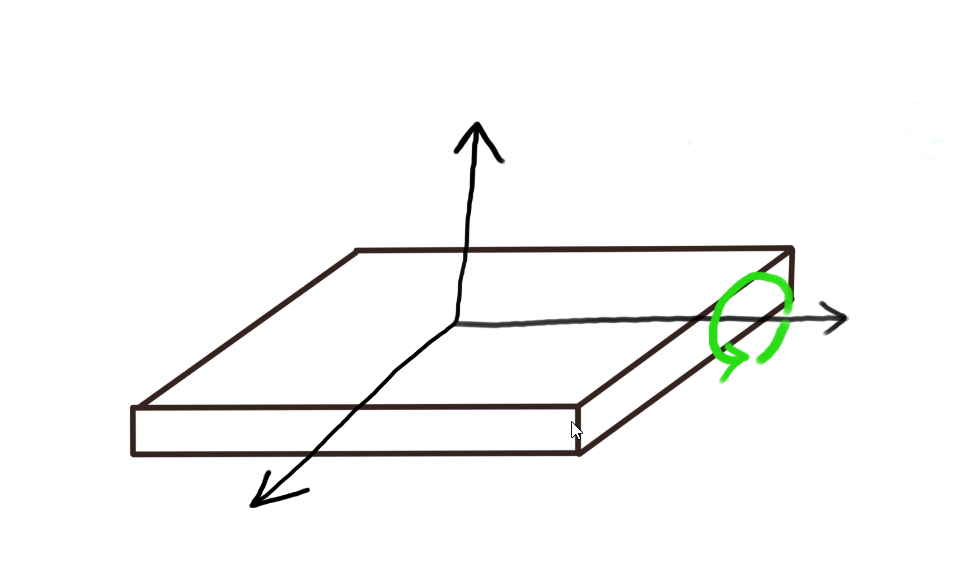
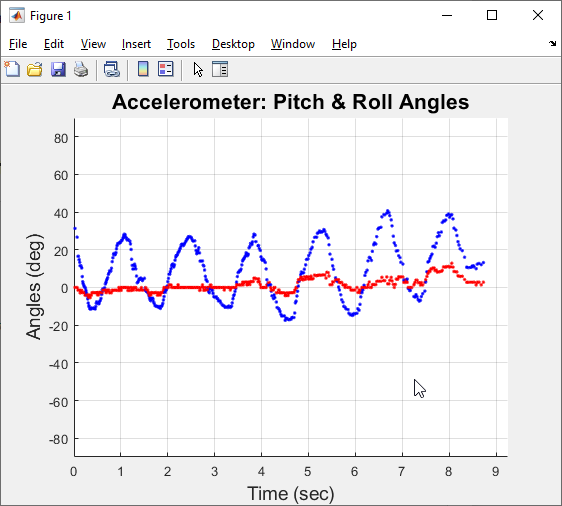

Board rotated along the vertical axis to my left and right
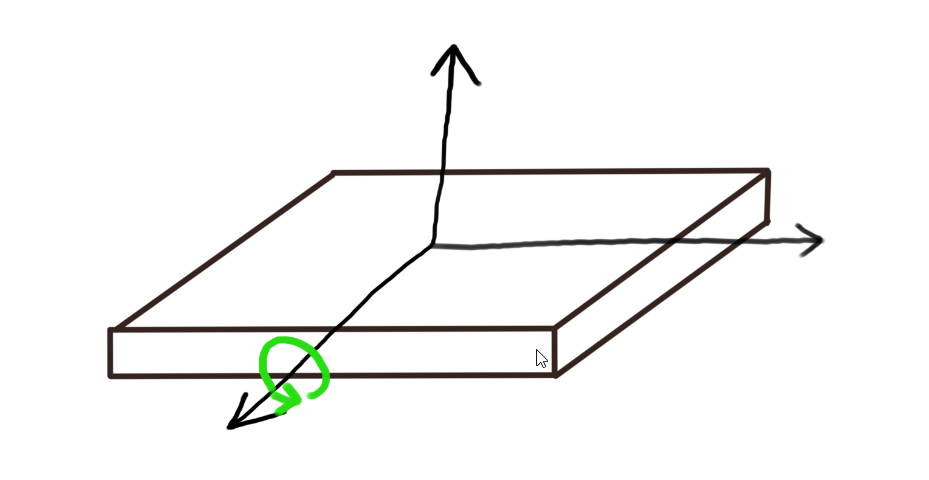
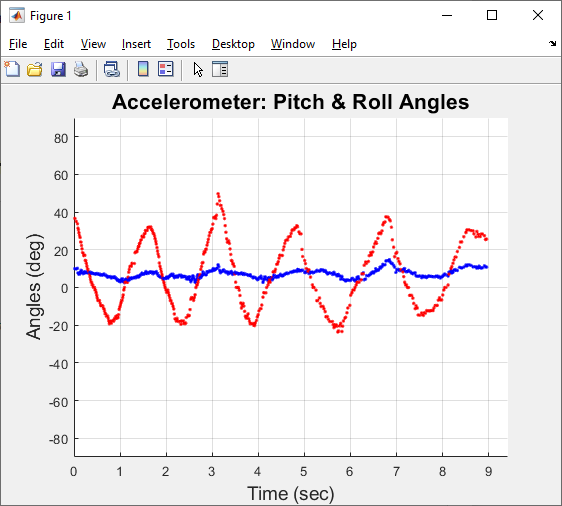

Board moved forward and back while rotating
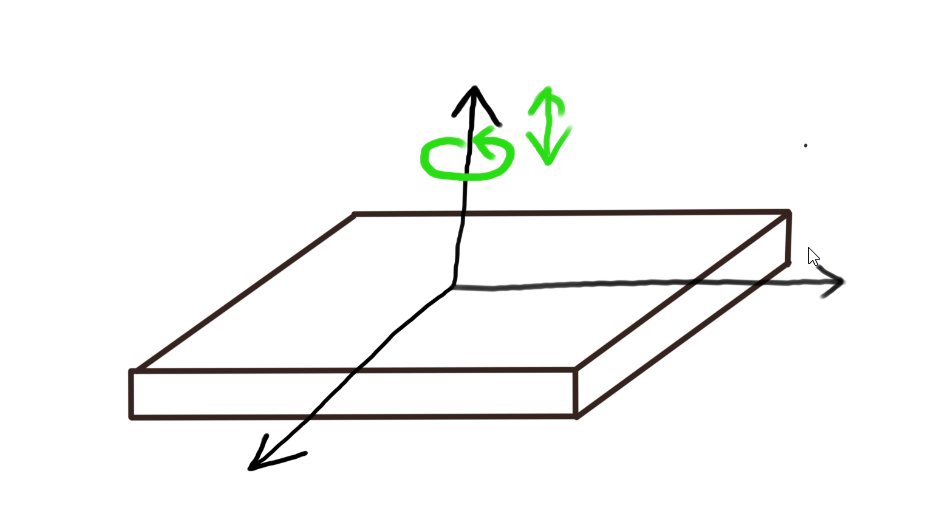
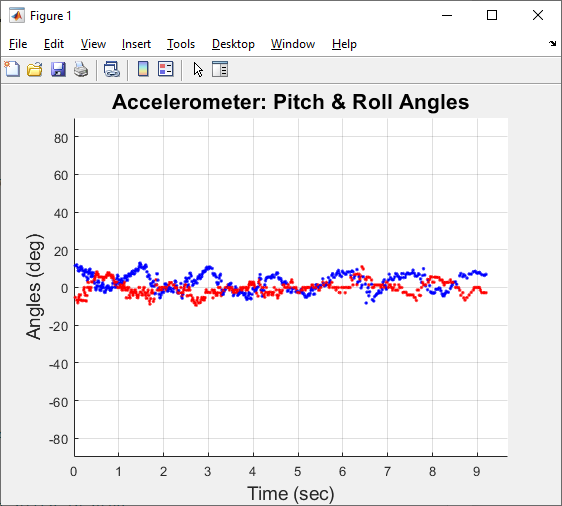

**The accelerometer produces noisy readings when it is in motion because the motion introduces additional forces on the PyBench other than those due to gravity**

### Testing the Gyroscope

In [7]:
%%file lab4task1b.m
% Lab 4 - Task 1b: testing the gyroscope
clear all
close('all')
ports = serialportlist;
pb = PyBench(ports(end));  % create a PyBench object
N = 500;            % each graph is 500 time points
end_time = 10.0;    % initial guess of time axis range
gx = 0; gy = 0; % initialise angles gy pitch, gx roll
while true
    % Plot the axes first for plot later
    figure(1)
    clf(1)
    axis([0 end_time -90 90]); %[xmin xmax ymin ymax]
    title('Gyroscope Pitch & Roll Angles','FontSize', 16);
    ylabel('Angles (deg)','FontSize', 14);
    xlabel('Time (sec)','FontSize', 14);
    grid on; hold on;
    timestamp = 0;
    tic;
    % read gyroscope data
    for i = 1:N
        [x, y, z] = pb.get_gyro();  % angular rate in rad/sec
        dt = toc;        % get elapsed time
        tic;
        timestamp = timestamp + dt;
        gx = max(min(gx+x*dt,pi/2),-pi/2);  % accumulate gx and gy and limit to +/- pi/2
        gy = max(min(gy+y*dt,pi/2),-pi/2);
        plot(timestamp, gy*180/pi,'.b');    % plot pitch in blue
        plot(timestamp, gx*180/pi,'.r');    % plot roll in red
        pause(0.001);         % delay for 1 ms, needed for plot
    end  % for loop
    end_time = timestamp;     % use actual time range from now on
end  % while

Created file 'C:\Users\shenl\OneDrive - Imperial College London\Year 2\Electronics 2\LogBook-Electronics2\Lab_4\lab4task1b.m'.


The way the gyropscope gets the angle is by **integrating the angular velocity**. However this means that any errors get accumulated, resulting in high drift over time i.e. time-dependent drift.If the gyro does not read perfectly zero when stationary (and it won’t), the small rate will keep adding to the angle until it is far away from the actual angle.

In [8]:
lab4task1b

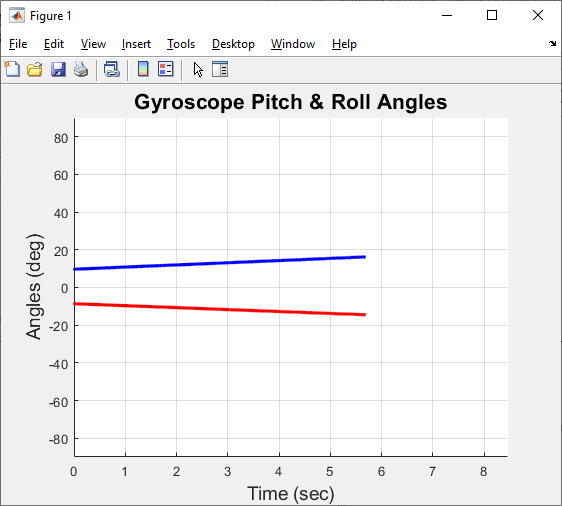

**The gyroscope reading drifts at a rate of approximately 1 degree a second**

Rotating anticlockwise around the y axis (rolling) results in a positive angular velocity and vice versa.

Rotating anticlockwise around the x axis (pitching) results in positive angular velocity and vice versa.

Rotation around the z axis was not plotted

## Task 2: Visualization in 3D

In [1]:
%%file lab4task2.m
% Lab 4 - Task 2: 3D display of roll and pitch angles
clear all
close('all')
ports = serialportlist;
pb = PyBench(ports(end));  % create a PyBench object
model = IMU_3D();  % create the IMU 3D visualisation object
N = 50;
tic;
gx = 0; gy = 0; 	% initialise gyro angles
fig1 = figure(1);
while true
    for i = 1:N
        [p, r] = pb.get_accel();
        [x, y, z] = pb.get_gyro();
        dt = toc;
        tic;
        pitch = p*180/pi;
        roll = r*180/pi;
        gx = max(min(gx+x*dt,pi/2),-pi/2);
        gy = max(min(gy+y*dt,pi/2),-pi/2);
        clf(fig1);
        subplot(2,1,1);
        model.draw(fig1, p, r, 'Accelerometer');
        subplot(2,1,2);
        model.draw(fig1, gy, gx, 'Gyroscope');
        pause(0.1);
    end  % for
end  % while

Created file 'C:\Users\shenl\OneDrive - Imperial College London\Year 2\Electronics 2\LogBook-Electronics2\Lab_4\lab4task2.m'.


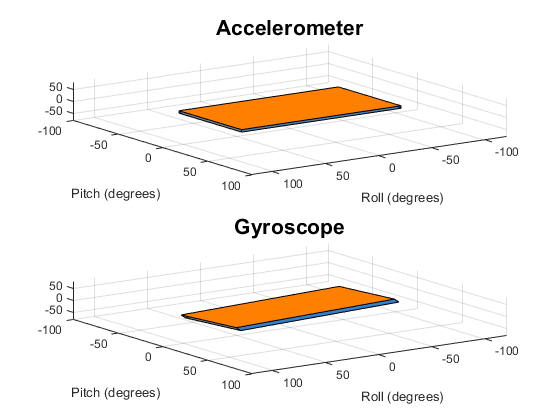

In [3]:
lab4task2

## Task 3: Combining two measurements using the Complementary Filter

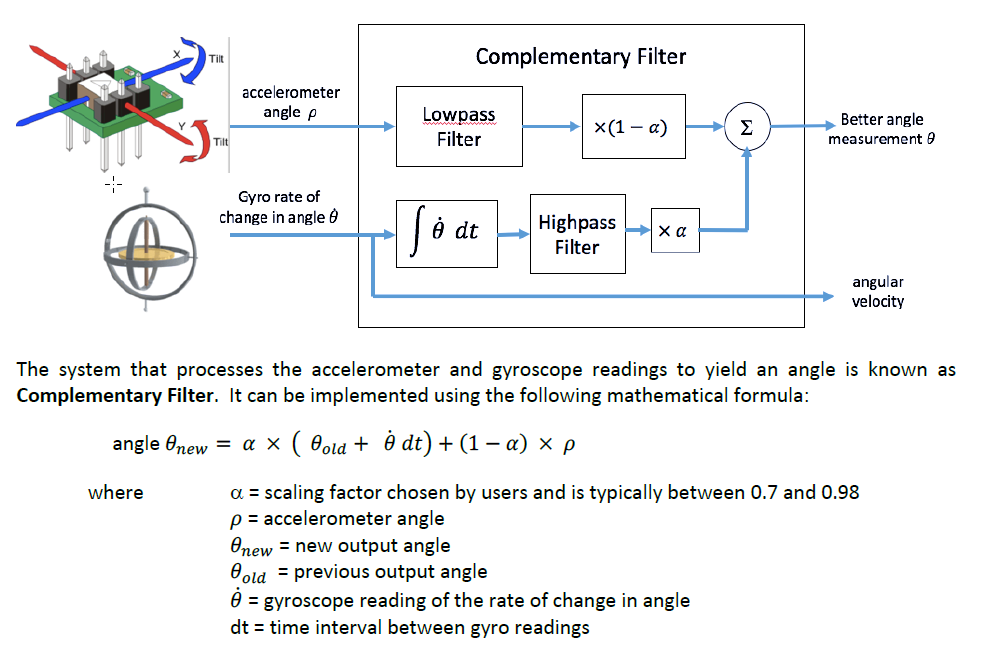

**Low-Pass Filter**: The goal of the low-pass filter is to only let through long-term changes, filtering out short-term fluctuations. One way to do this is to force the changes to build up little by little in subsequent times through the program loop. The time it takes to reach the full value depends on both the filter constants (0.98 and 0.02 in the example) and the sample rate of the loop (dt).

**High-Pass Filter**: Conceptually it does the exact opposite: It allows short-duration signals to pass through while filtering out signals that are steady over time. This can be used to cancel out drift.

**Time Constant**: The time constant of a filter is the relative duration of signal it will act on. For a low-pass filter, signals much longer than the time constant pass through unaltered while signals shorter than the time constant are filtered out. The opposite is true for a  highpass filter. The time constant, τ, of a digital low-pass filter,

y=(a)*(y) + (1-a)*(x);

running in a loop with sample perios, dt, can be found like this:

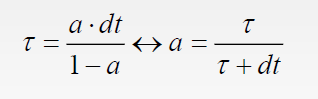

so if you know the desired time constant, and the sample rate, you can pick the filter coefficient a.

**Complementary**: This just means the two parts of the filter always add to one, so that the
output is an accurate, linear estimate in units that make sense.

The time constant defines where the boundary between trusting the gyroscope and trusting the accelerometer is. For time periods shorter than the time constant, the gyroscope integration takes precedence and the noisy horizontal accelerations are filtered out. For time periods longer than half a second, the accelerometer average is given more weighting than the gyroscope, which may have drifted by this point.

When designing a filter, the time constant is chosen first and then that is used to calculate the filter coefficients.

### 3D display of the effects of Complementary Filter

In [1]:
%%file lab4task3.m
% Lab 4 - Task 3: 3D display of effects of Complementary Filter
clear all
close('all')
ports = serialportlist;
pb = PyBench(ports(end));  % create a PyBench object
model = IMU_3D();
N = 50;
fig1 = figure(1);
gx = 0; gy = 0;             % gyro initial angles
angle_x = 0; angle_y = 0;   % combined angle using filter
alpha = 0.7; beta = 1-alpha; % weighting factor
tic
while true
    for i = 1:N
        [p, r] = pb.get_accel();
        [x, y, z] = pb.get_gyro();
        dt = toc;
        tic;
        % integration for gyro angles
        gx = max(min(gx+x*dt,pi/2),-pi/2);
        gy = max(min(gy+y*dt,pi/2),-pi/2);
        
        % complementary filtered angles
        angle_x = alpha*(angle_x + x*dt) + beta*r;
        angle_y = alpha*(angle_y + y*dt) + beta*p;
                
        figure(fig1)
        clf(fig1);
        subplot(3,1,1);
        model.draw(fig1, p, r, 'Accelerometer');
        subplot(3,1,2);
        model.draw(fig1, gy, gx, 'Gyroscope');
        subplot(3,1,3);
        model.draw(fig1, angle_y, angle_x, 'Filtered');
        pause(0.1);
    end  % for
 end  % while

Created file 'C:\Users\shenl\OneDrive - Imperial College London\Year 2\Electronics 2\LogBook-Electronics2\Lab_4\lab4task3.m'.


Result: Note the Gyroscope model drifting over time bu the filtered diagram is stable

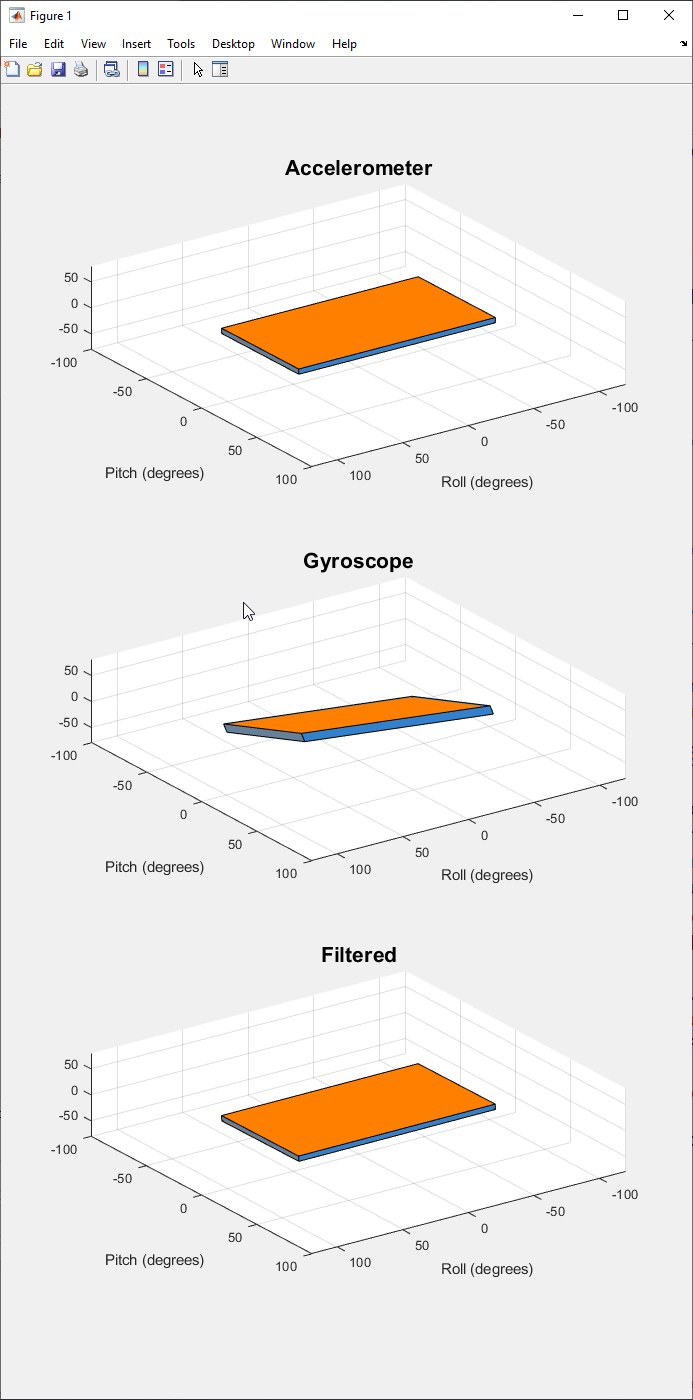

The following is the result of the script gyro_filtered
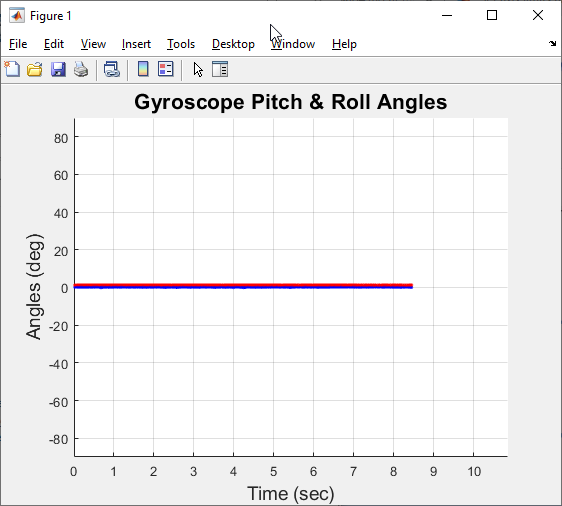

In [3]:
%%file gyro_filtered.m
% Lab 4 - Task 1b: testing the gyroscope
clear all
close('all')
ports = serialportlist;
pb = PyBench(ports(end));  % create a PyBench object
N = 500;            % each graph is 500 time points
end_time = 10.0;    % initial guess of time axis range
gx = 0; gy = 0; % initialise angles gy pitch, gx roll
angle_x = 0; angle_y = 0;   % combined angle using filter
alpha = 0.7; beta = 1-alpha; % weighting factor
while true
    % Plot the axes first for plot later
    figure(1)
    clf(1)
    axis([0 end_time -90 90]);
    title('Gyroscope Pitch & Roll Angles','FontSize', 16);
    ylabel('Angles (deg)','FontSize', 14);
    xlabel('Time (sec)','FontSize', 14);
    grid on; hold on;
    timestamp = 0;
    tic;
    % read gyroscope data
    for i = 1:N
        [p, r] = pb.get_accel();
        [x, y, z] = pb.get_gyro();  % angular rate in rad/sec
        dt = toc;        % get elapsed time
        tic;
        timestamp = timestamp + dt;
        
        gx = max(min(gx+x*dt,pi/2),-pi/2);  % limit to +/- pi/2
        gy = max(min(gy+y*dt,pi/2),-pi/2);
        
        % complementary filtered angles
        angle_x = alpha*(angle_x + x*dt) + beta*r;
        angle_y = alpha*(angle_y + y*dt) + beta*p;
        
        plot(timestamp, angle_y*180/pi,'.b');    % plot pitch in blue
        plot(timestamp, angle_x*180/pi,'.r');    % plot roll in red
        pause(0.001);         % delay for 1 ms, needed for plot
    end  % for loop
    end_time = timestamp;     % use actual time range from now on
end  % while

Created file 'C:\Users\shenl\OneDrive - Imperial College London\Year 2\Electronics 2\LogBook-Electronics2\Lab_4\gyro_filtered.m'.


## Task 4: Using the OLED driver on the PyBench Board
The 3-way DIP Switch was set to '000' and the PyBoard was reset. Upon boot up,
1. PyBoard runs the boot.py
2. boot.py runs main.py
3. main.py checks the configuration of the switches
4. '000' executes the 'user.py' file

user.py contains only one line "execfile('lab4task2.py")

lab4task4.py is as follows:
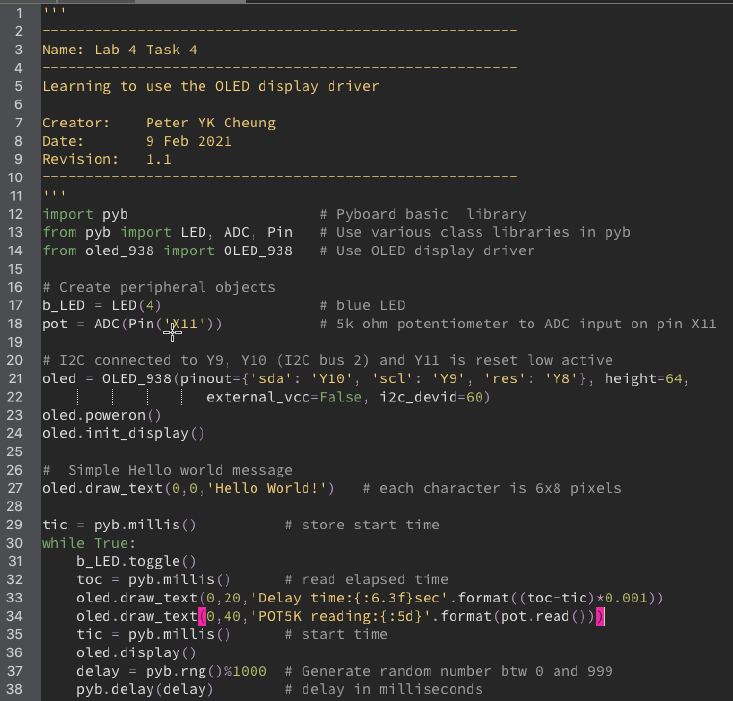

pot.read() reads the potentiometer value, effectively acting as an input

and the result is
<img src='task4a.jpg'>



Now, the code is modified so that "Hello World" is in the middle of the screen.
**The OLED display is 128x64 pixels and each character is 6 x 8 pixels including a 1-pixel gap on the right and bottom**

Modified code:
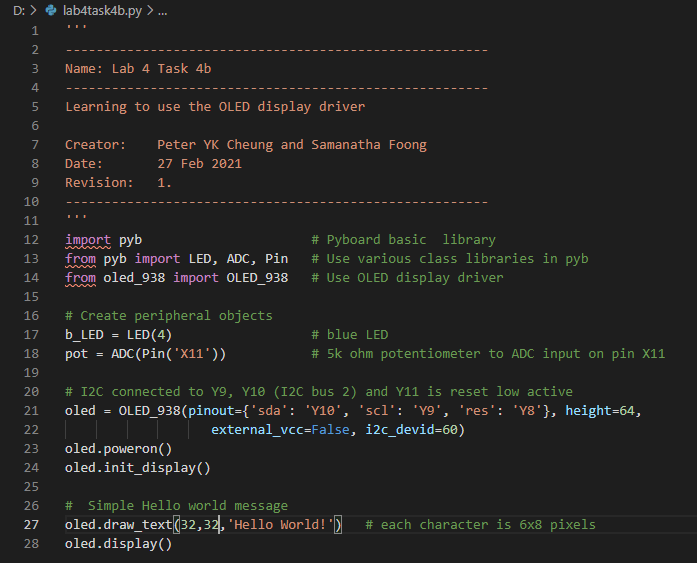

Results:
<img src='task4b.jpg'>

## Task 5: Using the IMU driver on the PyBench Board

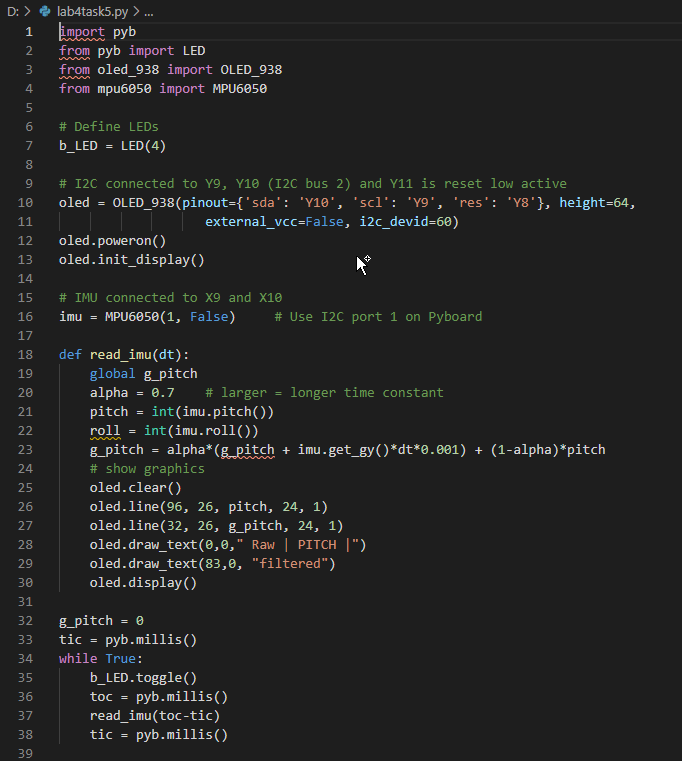

Result:
<img src='task5_1.jpg'>
<img src='task5_2.jpg'>